## `Imports`

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule, OneSidedSelection
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures

In [2]:
# setting random seed
np.random.seed(24)

#### Reading in data

In [3]:
# reading in session dataframe
session = pd.read_csv('../data/session_cleaned.csv')

# reading in train dataframe
train = pd.read_csv('../data/train_cleaned.csv')

## `Preprocessing`

#### Feature Extraction: Session data

In [4]:
# action, action_type, action_detail transformed into columns with frequency counts
session2 = pd.crosstab(session['user_id'], session['action'])
action_names = {each :'action_'+each for each in session2.columns}
session2 = session2.rename(columns=action_names)

session3 = pd.crosstab(session['user_id'], session['action_type'])
action_type_names = {each :'action_type_'+each for each in session3.columns}
session3 = session3.rename(columns=action_type_names)


session4 = pd.crosstab(session['user_id'], session['action_detail'])
action_detail_names = {each :'action_detail_'+each for each in session4.columns}
session4 = session4.rename(columns=action_detail_names)

session_actions = pd.concat([session2, session3, session4], axis=1)

#### Merge

In [5]:
# merging train df and session actions df
df = train.merge(session_actions, on='user_id')

In [6]:
# class population train data
class_population = pd.DataFrame()
class_population_percent = pd.DataFrame()
class_population['train'] = train['country_destination'].value_counts()
class_population_percent['train%'] = train['country_destination'].value_counts(normalize=True)

# class population train and sess (meta data)
class_population['merged'] = df['country_destination'].value_counts()
class_population_percent['merged%'] = df['country_destination'].value_counts(normalize=True)

# merge train, sess(meta), and session df
multiples = train.merge(session, on='user_id')
class_population['merged_multiples'] = multiples['country_destination'].value_counts()
class_population_percent['merged_multiples%'] = multiples['country_destination'].value_counts(normalize=True)

In [7]:
class_population

,train,merged,merged_multiples
NDF,124015,44116,3004858
US,62117,19777,1651366
other,10049,3606,316666
FR,5003,1417,144576
IT,2820,970,100407
GB,2312,724,64131
ES,2239,699,65625
CA,1422,431,38858
DE,1053,249,23141
NL,757,245,22316


In [8]:
class_population_percent

,train%,merged%,merged_multiples%
NDF,0.583487,0.608790,0.551365
US,0.292259,0.272918,0.303011
other,0.047280,0.049762,0.058105
FR,0.023539,0.019554,0.026528
IT,0.013268,0.013386,0.018424
GB,0.010878,0.009991,0.011767
ES,0.010534,0.009646,0.012042
CA,0.006690,0.005948,0.007130
DE,0.004954,0.003436,0.004246
NL,0.003562,0.003381,0.004095


In [9]:
print(f'Train total user population {len(train)}')
print(f'Train_session_u total user population {len(df)}')
print(f'Train_session_m total user population {len(multiples)}')

Train total user population 212541
Train_session_u total user population 72465
Train_session_m total user population 5449850


**Notes**:
* _train_ : train data only; 1 row per user; will be dropped because it does not include session data however maintains more overall unique users 
* _merged_ : train & session data; 1 row per user
* _merged_multiples_ : train & session data; multiple rows per user, increases overall samples however introduces multiple entries per user 

**Merged data per unique user (df) will be used**

#### Feature Extraction: Train data

In [10]:
# date account created to datetime
df['date_account_created'] = pd.to_datetime(df['date_account_created'])

In [11]:
# year account created
df['year_account_created'] = [pd.to_datetime(each).year for each in df['date_account_created']]

# month account created
df['month_account_created'] = [pd.to_datetime(each).month for each in df['date_account_created']]

# day account created
df['day_account_created'] = [pd.to_datetime(each).day for each in df['date_account_created']]

# month day account created
df['month_day_account_created'] = [str(pd.to_datetime(each))[5:10] for each in df['date_account_created']]

# quarter account created
df['quarter_account_created'] = [pd.to_datetime(each).quarter for each in df['date_account_created']]

In [12]:
# remove time from timestamp 
df['timestamp_first_active'] = [dt.datetime.strptime(str(each)[:8], '%Y%m%d') for each in df['timestamp_first_active']]

In [13]:
# year first active
df['year_first_active'] = [pd.to_datetime(each).year for each in df['timestamp_first_active']]

# month first active
df['month_first_active'] = [pd.to_datetime(each).month for each in df['timestamp_first_active']]

# day first active
df['day_first_active'] = [pd.to_datetime(each).day for each in df['timestamp_first_active']]

# month day first active
df['month_day_first_active'] = [str(pd.to_datetime(each))[5:10] for each in df['timestamp_first_active']]

# quarter first active
df['quarter_first_active'] = [pd.to_datetime(each).quarter for each in df['timestamp_first_active']]

In [14]:
# year first booking
df['year_first_booking'] = [each if each=='no date' else str(pd.to_datetime(each).year) for each in df['date_first_booking']]

# month first booking
df['month_first_booking'] = [each if each=='no date' else str(pd.to_datetime(each).month) for each in df['date_first_booking']]

# day first booking
df['day_first_booking'] = [each if each=='no date' else str(pd.to_datetime(each).day) for each in df['date_first_booking']]

# month day first booking
df['month_day_first_booking'] = [each if each=='no date' else str(pd.to_datetime(each))[5:10] for each in df['date_first_booking']]

# quarter first booking
df['quarter_first_booking'] = [each if each=='no date' else str(pd.to_datetime(each).quarter) for each in df['date_first_booking']]

In [15]:
# created days until booked
dates = df[df['date_first_booking']!='no date']
df['days_until_booked'] = pd.to_datetime(dates['date_first_booking']) - dates['date_account_created']
df['days_until_booked'] = ['no date' if str(each) == 'NaT' else str(each).split()[0] for each in df['days_until_booked']]

In [16]:
# timestamps to strings
df['date_account_created'] = [str(each)[:10] for each in df['date_account_created']]
df['timestamp_first_active'] = [str(each)[:10] for each in df['timestamp_first_active']]

In [17]:
# dataframe copy
df_c = df.copy()

**Notes**:
* 3 features: changed <u>date account created</u>, <u>timestamp first active</u>, <u>date first booking</u> to date time, for extraction then changed to string
* Extracted year, month, day, month & day, quarter, days until booked

#### One hot encoding

In [18]:
# instantiate ohe
ohe = OneHotEncoder(drop='first')

# ohe df of train data
g = pd.DataFrame(ohe.fit_transform(df[[
    'date_account_created',
    'timestamp_first_active',
    'date_first_booking',
    'gender',
    'signup_method',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'year_account_created',
    'month_account_created',
    'day_account_created',
    'month_day_account_created',
    'year_first_active',
    'month_first_active',
    'day_first_active',
    'month_day_first_active',
    'year_first_booking',
    'month_first_booking',
    'day_first_booking',
    'month_day_first_booking',
    'quarter_account_created',
    'quarter_first_active',
    'quarter_first_booking',
    'days_until_booked'
]]).toarray(), columns=ohe.get_feature_names_out([
    'date_account_created',
    'timestamp_first_active',
    'date_first_booking',
    'gender',
    'signup_method',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'year_account_created',
    'month_account_created',
    'day_account_created',
    'month_day_account_created',
    'year_first_active',
    'month_first_active',
    'day_first_active',
    'month_day_first_active',
    'year_first_booking',
    'month_first_booking',
    'day_first_booking',
    'month_day_first_booking',
    'quarter_account_created',
    'quarter_first_active',
    'quarter_first_booking',
    'days_until_booked'
]))

# ohe from float to int
g = g.astype('int')

# add user_id 
g['user_id'] = df['user_id']

# list of ohe feature names
non_numeric_cols = [each for each in g.columns]

#### Groups

**Notes**:
##### <u> 2 Groups</u>:
* g1 - session data encoded by frequency
* g2 - session data binarized

##### <u>Issues</u>:
* **Distribution of classes**: Balancing data may misrepresent the distrubtion of classes in the real world. Can be remedied by using bayseian inference; need historical data for first time users
* **Multiple entries from session data**: Session data creates multiple instances of a user and introduces bias for repeated features. The focus of the project is to find which destination a first time users chooses. Multiple entries implies more first time users committing to a particular class destination
* **Sec elapsed per action** is a leftover feature

#### Secs elapsed

In [19]:
# secs elapsed df
secs_elapsed = multiples[['country_destination', 'secs_elapsed']].copy()

# country destination transformed
le = LabelEncoder()
secs_elapsed['country_destination'] = le.fit_transform(secs_elapsed['country_destination'])

In [20]:
secs_elapsed.corr()

,country_destination,secs_elapsed
country_destination,1.00000,0.01131
secs_elapsed,0.01131,1.00000


**Notes** :
* **Secs_elapsed** has a weak correlation and will be dropped

In [21]:
# creation of g1 df
g1 = g.copy()

# added country destination 
g1['country_destination'] = df_c['country_destination']

# added oridinal/continuous data
g1['signup_flow'] = df_c['signup_flow']
g1['age'] = df_c['age']

In [22]:
# merge ohe train data with session data
g1 = g1.merge(session_actions, on='user_id')

In [23]:
# action, action_type, action_detail transformed into binary columns
# g1 copy
g2 = g1.copy()

# column names for session df
cols = [each for each in session_actions]

# binarize features
for each in cols:
    x = [0 if value == 0 else 1 for value in g2[each]]
    g2[each] = x

In [24]:
g1.to_csv('../data/g1.csv', index=False)
g2.to_csv('../data/g2.csv', index=False)

#### Set up

In [25]:
g1 = pd.read_csv('../data/g1.csv')
g2 = pd.read_csv('../data/g2.csv')

In [26]:
# setting X and y
X = g1.drop(columns=['country_destination'])
y = g1['country_destination']

# setting X and y for g2
# X = g2.drop(columns=['country_destination'])
# y = g2['country_destination']

In [27]:
# transforming target 
le = LabelEncoder()
y = le.fit_transform(y)

In [28]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=24)

## `Imputation`

In [29]:
# check X_train
X_train.head(3)

,date_account_created_2014-01-02,date_account_created_2014-01-03,date_account_created_2014-01-04,date_account_created_2014-01-05,date_account_created_2014-01-06,date_account_created_2014-01-07,date_account_created_2014-01-08,date_account_created_2014-01-09,date_account_created_2014-01-10,date_account_created_2014-01-11,...,action_detail_view_resolutions,action_detail_view_search_results,action_detail_view_security_checks,action_detail_view_user_real_names,action_detail_wishlist,action_detail_wishlist_content_update,action_detail_wishlist_note,action_detail_your_listings,action_detail_your_reservations,action_detail_your_trips
52596,0,0,0,0,0,0,0,0,0,0,...,0,11,0,0,0,0,0,0,0,0
19141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


#### KNN Imputer

In [30]:
# instantiating knnimputer
knni = KNNImputer(n_neighbors=2, weights='uniform')

In [31]:
# fit & transforming knnimputer
train_knni = knni.fit_transform(X_train.drop(columns=non_numeric_cols))

In [32]:
# train knni df
train_knni = pd.DataFrame(train_knni, columns=X_train.drop(columns=non_numeric_cols).columns)

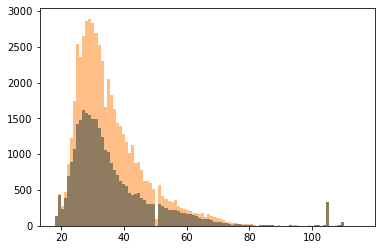

In [33]:
# checking distribution of imputed data vs non-imputed data
plt.hist(X_train['age'], bins=100)
plt.hist(train_knni['age'], bins=100, alpha=.5);

#### Iterative Imputer

In [10]:
# instantiating iterative imputer
imp = IterativeImputer(random_state=24)

In [11]:
# fit on age
train_iimp = imp.fit_transform(X_train.drop(columns=non_numeric_cols))

In [26]:
# dataframe of imputed age values and if age was imputed or not
train_iimp_df = pd.DataFrame(train_iimp, columns=X_train.drop(columns=non_numeric_cols).columns)

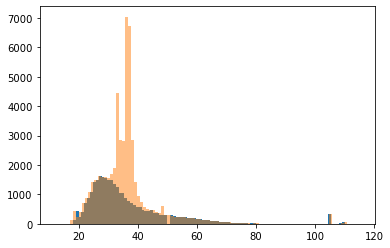

In [32]:
plt.hist(X_train['age'], bins=100)
plt.hist(train_iimp_df['age'], bins=100, alpha=.5);

#### Imputation to X_train

**Note**: 
* KNNI imputation chosen because distribution looks more similar to original distribution

In [34]:
# reset index for x_train
X_train.reset_index(drop=True, inplace=True)

# adding age imp and age imp values features
X_train['age_present'] = [1 if each==-1 else 0 for each in X_train['age'].fillna(-1)]
X_train['age'] = train_knni['age'].copy().astype('int')

In [35]:
# reset index for x_test
X_test.reset_index(drop=True, inplace=True)

# X_test transformation
X_test['age_present'] = [1 if each==-1 else 0 for each in X_test['age'].fillna(-1)]

**Notes**:
* Imputation highly skews the data with respect to age and feature may need to be dropped
* Iterative Imputer and KNNImputer produce similar results; iterative imputer will be used for now--less computer intensive

## `Feature Engineering`

#### Session data

In [36]:
# new dataframe count action
sess = pd.DataFrame(session.groupby(by='user_id')['action'].count())

# rename dataframe
sess.rename(columns={'action': 'count_action'}, inplace=True)

In [37]:
# total secs elapsed
sess['total_secs_elapsed'] = session.groupby(by='user_id')['secs_elapsed'].sum()

In [38]:
# unique actions
actions = session.groupby(by='user_id')['action'].unique()

# count of unique actions 
sess['unique_actions'] = [len(set(each)) for each in actions]

In [39]:
# mean secs elapsed per action
sess['mean_secs_elapsed_per_action'] = sess['total_secs_elapsed']/sess['count_action']

In [40]:
# total mins elapsed
sess['total_mins_elapsed'] = sess['total_secs_elapsed']/60

# mean mins elapsed per action
sess['mean_mins_elapsed_per_action'] = sess['total_mins_elapsed']/sess['count_action']

In [41]:
# log transformations
sess['log_total_mins'] = np.log(sess['total_mins_elapsed']+1)

sess['log_mean_mins'] = np.log(sess['mean_mins_elapsed_per_action']+1)

sess['log_total_secs'] = np.log(sess['total_secs_elapsed']+1)

sess['log_mean_secs'] = np.log(sess['mean_secs_elapsed_per_action']+1)

**Notes**:
* Extracted: count of actions taken, count of unique actions taken, mean seconds elapsed per action, and logs of time features

#### Merge session meta

In [42]:
# merge train df and sess df
X_train = X_train.merge(sess, on='user_id')

In [43]:
# merge test df and sess df
X_test = X_test.merge(sess, on='user_id')

In [44]:
X_train = X_train.drop(columns='user_id')
X_test = X_test.drop(columns='user_id')

In [45]:
X_train.isnull().sum().sort_values(ascending=False)

date_account_created_2014-01-02    0
month_day_first_booking_12-29      0
month_day_first_booking_12-21      0
month_day_first_booking_12-22      0
month_day_first_booking_12-23      0
                                  ..
language_no                        0
language_pl                        0
language_pt                        0
language_ru                        0
log_mean_secs                      0
Length: 2751, dtype: int64

**Notes** :
* Featured engineered session data (sess data) merged with train data results in remaining user population

#### Save data

**Baseline**

In [46]:
# save baseline model data
X_train.to_csv('../data/X_train_b.csv', index=False)
X_test.to_csv('../data/X_test_b.csv', index=False)

In [ ]:
# save g2 model data
# X_train.to_csv('../data/X_train_g2.csv', index=False)
# X_test.to_csv('../data/X_test_g2.csv', index=False)

In [47]:
# save target
np.save('../data/y_train.npy', y_train)
np.save('../data/y_test.npy', y_test)

#### Polynomial features

In [48]:
# read in baseline model data
X_train = pd.read_csv('../data/X_train_b.csv')
X_test = pd.read_csv('../data/X_test_b.csv')

In [49]:
# read in target
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

In [50]:
# instantiate polynomial features
pf = PolynomialFeatures(degree=3, include_bias=False)

In [51]:
# numeric cols
num_cols = ['signup_flow',
            'count_action',
            'total_secs_elapsed',
            'mean_secs_elapsed_per_action',
            'unique_actions',
            'log_total_secs',
            'log_mean_secs']

In [52]:
# fit pf
pf.fit(X_train[num_cols])

# transform train
X_train_pf = pd.DataFrame(pf.transform(X_train[num_cols]),
                          columns=pf.get_feature_names_out(num_cols)
                         )
# transform test
X_test_pf = pd.DataFrame(pf.transform(X_test[num_cols]),
                          columns=pf.get_feature_names_out(num_cols)
                         )
# create copy of target and add to train data
X_train_pf['country_destination'] = y_train.copy()

In [53]:
# correlation of train data
X_train_pf.corr()['country_destination'].sort_values(ascending=False).drop_duplicates()

country_destination                              1.000000
unique_actions log_mean_secs^2                   0.163366
unique_actions log_mean_secs                     0.157828
unique_actions log_total_secs log_mean_secs      0.154518
mean_secs_elapsed_per_action unique_actions^2    0.150953
                                                   ...   
signup_flow log_total_secs                      -0.046137
signup_flow^3                                   -0.046752
signup_flow log_mean_secs                       -0.047077
signup_flow^2                                   -0.048609
signup_flow                                     -0.051387
Name: country_destination, Length: 118, dtype: float64

In [54]:
# value counts correlations
X_train_pf.corr()['country_destination'].value_counts()

 0.072154    2
 0.094352    2
-0.051387    1
 0.065146    1
 0.011684    1
            ..
-0.011064    1
-0.046752    1
 0.078270    1
 0.091564    1
 1.000000    1
Name: country_destination, Length: 118, dtype: int64

In [55]:
# drop original numeric columns & country destination on X_train
X_train_pf = X_train_pf.drop(columns=num_cols)
X_train_pf = X_train_pf.drop(columns='country_destination')
X_test_pf = X_test_pf.drop(columns=num_cols)

# add pf cols to x train and x test
X_train = pd.concat([X_train, X_train_pf], axis=1)
X_test = pd.concat([X_test, X_test_pf], axis=1)

#### Save data

In [56]:
# save X_train and X_test with pf features
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)